In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Density map comparison between two directories

We first investigate 2 ground truth density folders. We find discrepancies for 2 files. We visualize the ground truth density maps from both folders below.

In [2]:
import os
err = 0
for file in os.listdir("../data/gt_density_map_adaptive_384_VarV2/"):
    dens_0 = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file}")
    dens_1 = np.load(f"../data/gt_density_map_special/{file}")
    
    diff = np.sum(np.abs(dens_0 - dens_1))
    if diff > 0:
        print(file)
    err += diff
    
print(err)

3471.npy
3477.npy
417.9150242960926


We see that the density map is more blurred in the second folder than in the first.

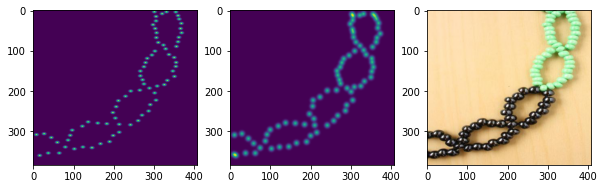

In [3]:
file_name = "3471.npy"
dens_0 = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file_name}")
dens_1 = np.load(f"../data/gt_density_map_special/{file_name}")
img = Image.open(f"../data/images_384_VarV2/{file_name.replace('.npy', '.jpg')}")

f, axarr = plt.subplots(1,3, figsize=(10, 10))
axarr[0].imshow(dens_0)
axarr[1].imshow(dens_1)
axarr[2].imshow(img)

We see that different elements are considered for counting from both images.

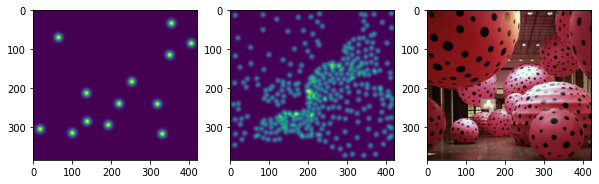

In [4]:
file_name = "3477.npy"
dens_0 = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file_name}")
dens_1 = np.load(f"../data/gt_density_map_special/{file_name}")
img = Image.open(f"../data/images_384_VarV2/{file_name.replace('.npy', '.jpg')}")

f, axarr = plt.subplots(1,3, figsize=(10, 10))
axarr[0].imshow(dens_0)
axarr[1].imshow(dens_1)
axarr[2].imshow(img)

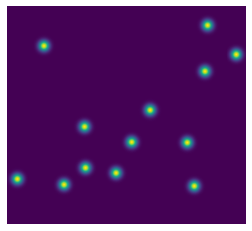

In [5]:
plt.imshow(dens_0)
plt.axis("off")
plt.savefig("ds_1.png", bbox_inches='tight')

## Re-generation of density maps

In [6]:
import scipy.spatial
import scipy.ndimage
import scipy.signal

Authors only provide the pre-computed density maps and describe the process in the paper. We try to replicate their results and verify that the pre-computed density maps are indeed corretly generated.

In [9]:
# gauss2D filter
import numpy as np

def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [10]:
import json
import cv2
with open('../data/annotation_FSC147_384.json') as json_file:
    data = json.load(json_file)

In [11]:
file = "4"
data[f"{file}.jpg"]

{'H': 534,
 'W': 799,
 'box_examples_coordinates': [[[338, 158], [338, 183], [354, 183], [354, 158]],
  [[201, 210], [201, 225], [215, 225], [215, 210]],
  [[259, 45], [259, 73], [278, 73], [278, 45]]],
 'box_examples_path': ['/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_0.jpg',
  '/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_1.jpg'],
 'density_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_adaptive_384_VarV2/4.npy',
 'density_path_fixed': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_fixed/4.npy',
 'img_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/images_384_VarV2/4.jpg',
 'points': [[66.24374217772215, 197.09842696629212],
  [24.899874843554443, 140.66337078651685],
  [143.1023153942428, 156.95101123595504],
  [269.4511889862328, 56.29842696629214],
  [348.0585106382979, 167.42831460674157],
  [515.744055068836, 58.04584269662921],
  [282.84386733416767, 212.81078651685394],
  [209.47559449311638, 218.62831460674155],
  [192.00969962453067, 208.

In [12]:
ratio_h = data[f"{file}.jpg"]["ratio_h"]
ratio_w = data[f"{file}.jpg"]["ratio_w"]

In [13]:
66.24374217772215 / ratio_h

92.12020396589487

In [14]:
pts = np.array(data[f"{file}.jpg"]["points"])
pts[:, 0] /= ratio_w
pts[:, 1] /= ratio_h
pts

array([[ 92.05, 274.09],
       [ 34.6 , 195.61],
       [198.85, 218.26],
       [374.42,  78.29],
       [483.65, 232.83],
       [716.66,  80.72],
       [393.03, 295.94],
       [291.08, 304.03],
       [266.81, 290.27],
       [176.19, 297.55]])

In [15]:
#pts1 = np.round(data[f"{file}.jpg"]["points"]).astype(np.int32)
pts1 = np.array(data[f"{file}.jpg"]["points"])#.astype(np.int32)
pts1

array([[ 66.24374218, 197.09842697],
       [ 24.89987484, 140.66337079],
       [143.10231539, 156.95101124],
       [269.45118899,  56.29842697],
       [348.05851064, 167.42831461],
       [515.74405507,  58.0458427 ],
       [282.84386733, 212.81078652],
       [209.47559449, 218.62831461],
       [192.00969962, 208.73348315],
       [126.79505632, 213.96853933]])

In [16]:
data[f"{file}.jpg"]

{'H': 534,
 'W': 799,
 'box_examples_coordinates': [[[338, 158], [338, 183], [354, 183], [354, 158]],
  [[201, 210], [201, 225], [215, 225], [215, 210]],
  [[259, 45], [259, 73], [278, 73], [278, 45]]],
 'box_examples_path': ['/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_0.jpg',
  '/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_1.jpg'],
 'density_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_adaptive_384_VarV2/4.npy',
 'density_path_fixed': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_fixed/4.npy',
 'img_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/images_384_VarV2/4.jpg',
 'points': [[66.24374217772215, 197.09842696629212],
  [24.899874843554443, 140.66337078651685],
  [143.1023153942428, 156.95101123595504],
  [269.4511889862328, 56.29842696629214],
  [348.0585106382979, 167.42831460674157],
  [515.744055068836, 58.04584269662921],
  [282.84386733416767, 212.81078651685394],
  [209.47559449311638, 218.62831460674155],
  [192.00969962453067, 208.

In [17]:
tree = scipy.spatial.KDTree(pts1.copy(), leafsize=10)

In [18]:
dists, neighbours = tree.query(pts1, k = 2, p = 2)
print(dists)
print(neighbours)

[[  0.          62.85747637]
 [  0.          69.95878024]
 [  0.          59.30366943]
 [  0.         136.12113335]
 [  0.          79.45135907]
 [  0.         200.20730999]
 [  0.          73.59855361]
 [  0.          20.07399246]
 [  0.          20.07399246]
 [  0.          59.30366943]]
[[0 9]
 [1 0]
 [2 9]
 [3 4]
 [4 6]
 [5 4]
 [6 7]
 [7 8]
 [8 7]
 [9 2]]


In [19]:
avg = np.average(dists[:, 1])
avg

78.09499363929407

In [20]:
w = avg
s = avg/8
print(f"{w}, {s}")

78.09499363929407, 9.76187420491176


In [21]:
#test = np.zeros(gt_generated.shape)
test = np.zeros((384, 575))
for i in range(pts.shape[0]):
    y = int(pts1[i, 1])
    x = int(pts1[i, 0])
    test[y, x] = 1
    
#plt.figure(figsize=(10, 10))
#plt.imshow(test)

In [22]:
#import cv2
#k = cv2.getGaussianKernel(41, 10)
#filt1 = np.outer(k, k)
filt = matlab_style_gauss2D((w, w), s )

#np.sum(np.abs(filt1- filt))

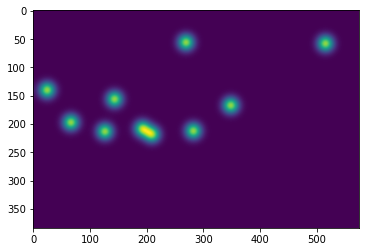

In [23]:
#pred = scipy.signal.convolve2d(test.copy(), filt, mode = "same")
pred = cv2.filter2D(test.copy(), -1, filt, 0)
plt.imshow(pred)

19.33098965826961
10.003802779096368


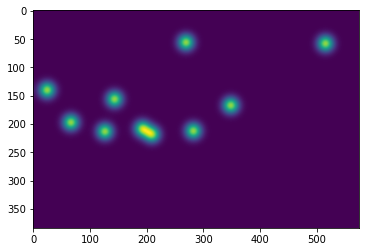

In [24]:
resized = cv2.resize(pred, (575, 384), interpolation = cv2.INTER_CUBIC)
resized = resized * (1 / ratio_w) * (1 / ratio_h)
plt.imshow(resized)
print(np.sum(resized))
print(np.sum(pred))

(384, 575)


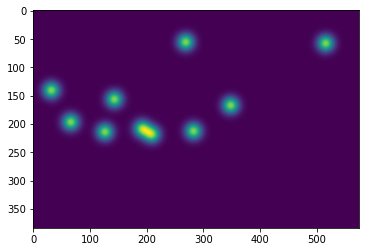

In [25]:
gt_generated = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file}.npy")

plt.imshow(gt_generated)
print(gt_generated.shape)

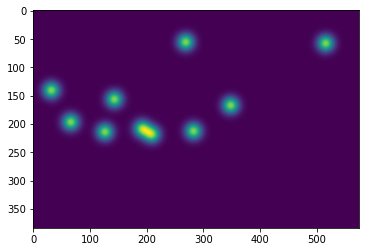

In [26]:
plt.imshow(gt_generated)

In [27]:
print(np.sum(resized))
print(np.sum(gt_generated))

19.33098965826961
9.999997


In [28]:
pred

array([[ 2.92604248e-20,  2.62422410e-20,  2.20300552e-20, ...,
        -7.07079783e-21, -7.76812648e-21, -8.30089233e-21],
       [-9.71861803e-20, -1.04240349e-19, -1.11226001e-19, ...,
        -1.38402115e-20, -1.22347676e-20, -1.03056025e-20],
       [-6.82420292e-20, -7.09149997e-20, -7.40539894e-20, ...,
        -2.39330961e-20, -2.51074101e-20, -2.60994411e-20],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [29]:
np.sum(np.abs(resized-gt_generated))

9.55961160704277

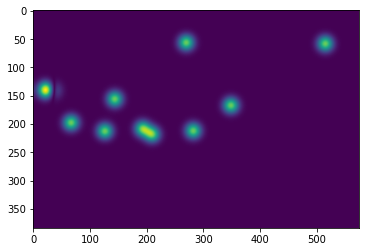

In [30]:
plt.imshow(np.abs(resized - gt_generated))

Put the above findings into a method for density map generation

In [31]:
def generate_gt_density(pts, shape):
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=10)
    dists, _ = tree.query(pts, k = 2, p = 2)
    avg = np.average(dists[:, 1])
    s = avg/8
    
    pred = np.zeros(shape)
    for i in range(pts.shape[0]):
        y = int(pts[i, 1])
        x = int(pts[i, 0])
        pred[y, x] = 1
        
    filt = matlab_style_gauss2D((avg, avg), s)
    
    pred = cv2.filter2D(pred, -1, filt, 0)
    
    return pred

In [32]:
def generate_gt_density_and_resize(pts, shape, out_shape):
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=10)
    dists, _ = tree.query(pts, k = 2, p = 2)
    avg = np.average(dists[:, 1])
    s = avg/8
    
    pred = np.zeros(shape)
    for i in range(pts.shape[0]):
        y = int(pts[i, 1])
        x = int(pts[i, 0])
        pred[y, x] = 1
        
    filt = matlab_style_gauss2D((avg, avg), s)
    
    pred = cv2.filter2D(pred, -1, filt, 0)
    
    resized = cv2.resize(pred, out_shape, interpolation = cv2.INTER_LINEAR)
    resized = resized * (1 / ratio_w) * (1 / ratio_h)
    
    return resized

Check differences

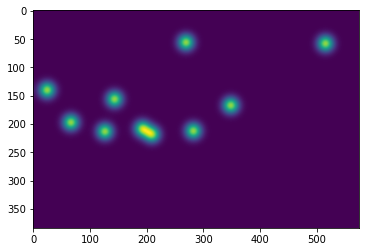

In [33]:
dens1 = generate_gt_density(pts1, (384, 575))
plt.imshow(dens1)

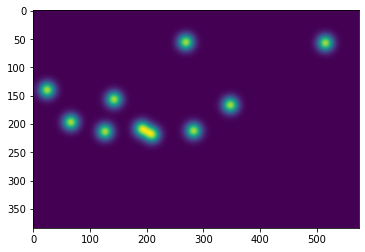

In [34]:
dens2 = generate_gt_density_and_resize(pts, (534, 799), (575, 384))
plt.imshow(dens2)

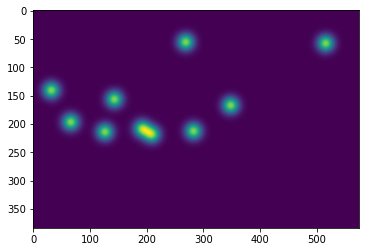

In [35]:
dens_gt = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file}.npy")
plt.imshow(dens_gt)

In [36]:
np.sum(np.abs(dens1 - dens2))

0.4868201874004124

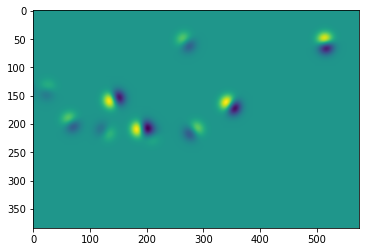

In [37]:
plt.imshow(dens2 - dens1)

In [38]:
np.sum(np.abs(dens2 - dens_gt))

1.111512752495817

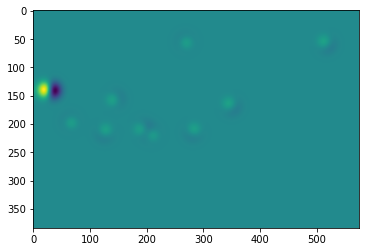

In [39]:
plt.imshow(dens2 - dens_gt)

## Another approach which confirms our claims

In [40]:
import numpy as np
import scipy.spatial
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt

def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def generate_gt_density(pts, resized_pts, shape):
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=10)
    dists, _ = tree.query(pts, k = 2, p = 2)
    print(dists)
    avg = np.average(dists[:, 1])
    print(avg)
    s = avg/8
    # To make the length of the filter an integer
    avg = int(np.round(avg))
    if avg % 2 == 0: avg+=1
    
    pred = np.zeros(shape)
    for i in range(resized_pts.shape[0]):
        y = int(resized_pts[i, 1])
        x = int(resized_pts[i, 0])
        pred[y, x] = 1
        """min_x, max_x = int(np.floor(resized_pts[i, 0])), int(np.ceil(resized_pts[i, 0]))
        min_y, max_y = int(np.floor(resized_pts[i, 1])), int(np.ceil(resized_pts[i, 1]))
        for x in [min_x, max_x]:
            for y in [min_y, max_y]:
                pred[y, x] = 1"""
        
        
    filt = matlab_style_gauss2D((avg, avg), s)
    
    pred = cv2.filter2D(pred, -1, filt)
    pred = pred - pred.min()
    
    return pred

In [41]:
import json
import cv2
with open('../data/annotation_FSC147_384.json') as json_file:
    data = json.load(json_file)

In [42]:
file = "4"
data[f"{file}.jpg"]

{'H': 534,
 'W': 799,
 'box_examples_coordinates': [[[338, 158], [338, 183], [354, 183], [354, 158]],
  [[201, 210], [201, 225], [215, 225], [215, 210]],
  [[259, 45], [259, 73], [278, 73], [278, 45]]],
 'box_examples_path': ['/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_0.jpg',
  '/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_1.jpg'],
 'density_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_adaptive_384_VarV2/4.npy',
 'density_path_fixed': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_fixed/4.npy',
 'img_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/images_384_VarV2/4.jpg',
 'points': [[66.24374217772215, 197.09842696629212],
  [24.899874843554443, 140.66337078651685],
  [143.1023153942428, 156.95101123595504],
  [269.4511889862328, 56.29842696629214],
  [348.0585106382979, 167.42831460674157],
  [515.744055068836, 58.04584269662921],
  [282.84386733416767, 212.81078651685394],
  [209.47559449311638, 218.62831460674155],
  [192.00969962453067, 208.

In [43]:
points = data[f"{file}.jpg"]["points"]
ratio_h = data[f"{file}.jpg"]["ratio_h"]
ratio_w = data[f"{file}.jpg"]["ratio_w"]
resized_points = [(x/ratio_w, y/ratio_h) for (x, y) in data[f"{file}.jpg"]["points"]]
print(points)
print(resized_points)

[[66.24374217772215, 197.09842696629212], [24.899874843554443, 140.66337078651685], [143.1023153942428, 156.95101123595504], [269.4511889862328, 56.29842696629214], [348.0585106382979, 167.42831460674157], [515.744055068836, 58.04584269662921], [282.84386733416767, 212.81078651685394], [209.47559449311638, 218.62831460674155], [192.00969962453067, 208.73348314606739], [126.7950563204005, 213.9685393258427]]
[(92.05, 274.09), (34.6, 195.61), (198.85, 218.26), (374.42, 78.29), (483.65000000000003, 232.82999999999998), (716.66, 80.72), (393.0299999999999, 295.94), (291.08, 304.03), (266.81, 290.27), (176.19, 297.55)]


In [44]:
gt_generated = np.load(f"../data/gt_density_map_special/{file}.npy")
print(gt_generated.shape)

print(data[f"{file}.jpg"]["H"]*ratio_h)
print(data[f"{file}.jpg"]["W"]*ratio_w)

(384, 575)
384.0
575.0


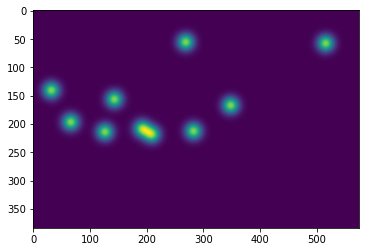

In [45]:
plt.imshow(gt_generated)

In [46]:
print(np.max(gt_generated))
print(np.sum(gt_generated))
gt_generated

0.0019172964
9.999997


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Creating density map directly on resized image

534
799
[[  0.          62.85747637]
 [  0.          69.95878024]
 [  0.          59.30366943]
 [  0.         136.12113335]
 [  0.          79.45135907]
 [  0.         200.20730999]
 [  0.          73.59855361]
 [  0.          20.07399246]
 [  0.          20.07399246]
 [  0.          59.30366943]]
78.09499363929407


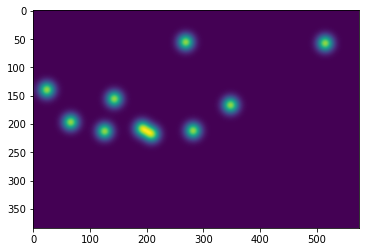

In [47]:
resized_points = [(x/ratio_w, y/ratio_h) for (x, y) in points]
h = data[f"{file}.jpg"]["H"]
print(h)
w = data[f"{file}.jpg"]["W"]
print(w)
pred = generate_gt_density(points, np.array(points), shape=gt_generated.shape)
plt.imshow(pred)

0.002005901119603197
0.0


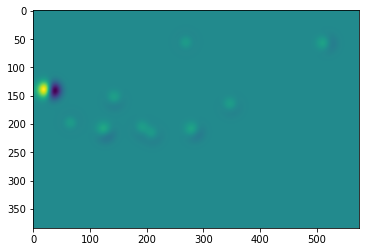

In [48]:
print(pred.max())
print(pred.min())
plt.imshow(pred - gt_generated)

### Creating density map on original shape and then resizing

534
799
[[  0.          87.34936291]
 [  0.          97.26054133]
 [  0.          82.46441475]
 [  0.         189.24535529]
 [  0.         110.43032419]
 [  0.         278.26446449]
 [  0.         102.27047766]
 [  0.          27.89929211]
 [  0.          27.89929211]
 [  0.          82.46441475]]
108.55479395769142


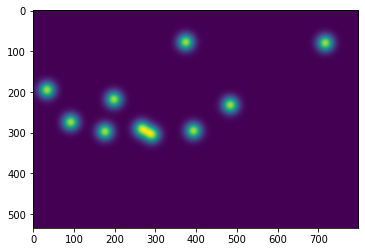

In [49]:
resized_points = [(x/ratio_w, y/ratio_h) for (x, y) in points]
h = data[f"{file}.jpg"]["H"]
print(h)
w = data[f"{file}.jpg"]["W"]
print(w)
pred = generate_gt_density(resized_points, np.array(resized_points), shape=(h, w))
plt.imshow(pred)

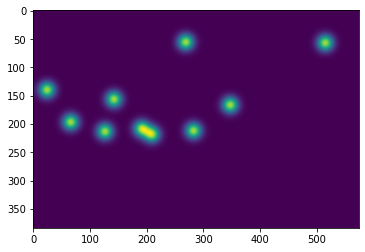

In [50]:
small_h, small_w = gt_generated.shape
original_sum = np.sum(pred)
resized = cv2.resize(pred, dsize=(small_w, small_h))
new_sum = np.sum(resized)
if new_sum != 0:
    resized *= (original_sum / new_sum)
resized = resized.round(decimals=10)
plt.imshow(resized)

In [51]:
print(np.max(resized))
print(np.sum(resized))
resized

0.0019288747
10.0012736951


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

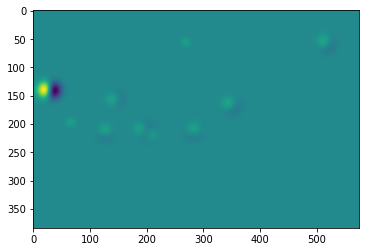

In [52]:
plt.imshow(resized - gt_generated)